In [82]:
# basic dependencies; setup logger
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, copy
import matplotlib.pyplot as plt
import cv2
import time
import datetime
import logging

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from fvcore.transforms.transform import NoOpTransform

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm

## Build custom dataset; register it

In [83]:
def get_weed_dicts(img_dir, file_list):
    json_file = os.path.join(img_dir, "_weed_labels.json")
    with open(json_file) as f:
        img_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(img_anns.values()):
        if v["filename"] in file_list:  # train or test data
            record = {}
            filename = os.path.join(img_dir, v["filename"])
            # print(filename)
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            annos = v["regions"]   # List of object attributes
            objs = []
            for anno in annos:
                if anno["region_attributes"]["label"] == "weed":
                    sa = anno["shape_attributes"]
                    obj = {
                        "bbox": [sa['x'], sa['y'], sa['width'], sa['height']],
                        "bbox_mode": BoxMode.XYWH_ABS, # or XYXY_ABS
                        "category_id": 0 if anno["region_attributes"]["label"] == "weed" else 1
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

In [84]:
# Create and register datasets
img_dir = '/home/mschoder/data/allweeds_600x400/'

json_file = os.path.join(img_dir, "_weed_labels.json")
print(json_file)
with open(json_file) as f:
    img_anns = json.load(f)

file_list = sorted([k for k in img_anns.keys()])
print("Number of images: ", len(file_list))
np.random.seed(31)
np.random.shuffle(file_list)
val_pct = 0.2  # 60-20-20 split
file_lists = {
    "val": file_list[:int(val_pct * len(file_list))],
    "test": file_list[int(val_pct * len(file_list)):int(2*val_pct * len(file_list))],
    "train": file_list[int(2*val_pct * len(file_list)):]
}

DatasetCatalog.clear()
for d in ["train", "val", "test"]:
    DatasetCatalog.register("weeds_" + d, lambda d=d: get_weed_dicts(img_dir, file_lists[d]))
    MetadataCatalog.get("weeds_" + d).set(thing_classes=["weed"])
weeds_metadata = MetadataCatalog.get("weeds_train")

# Build full dict
print('Creating datasets...')
# print(file_lists)
dataset_dicts = get_weed_dicts(img_dir, file_lists['train'])
print('Datasets created')

/home/mschoder/data/allweeds_600x400/_weed_labels.json
Number of images:  285
Creating datasets...
Datasets created


## Define custom transforms for vegetation color indices

In [85]:
## Define transformations
class HSV_EQ_Augmentation(T.Augmentation):
    def __init__(self):
        super().__init__()

    def get_transform(self, image):
        return HSV_EQ_Transform()

class HSV_EQ_Transform(T.Transform):
    def __init__(self):
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self,img):
        clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
        img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(img_HSV)
        cl2 = clahe.apply(v)
        img_HSV_new = cv2.merge((h,s,cl2))
        img_BGR = cv2.cvtColor(img_HSV_new,cv2.COLOR_HSV2BGR)
        return img_BGR

    def apply_coords(self, coords):
        return coords

    def inverse(self):
        return NoOpTransform()

    def apply_segmentation(self, segmentation):
        return segmentation

class HLS_EQ_Augmentation(T.Augmentation):
    def __init__(self):
        super().__init__()

    def get_transform(self, image):
        return HLS_EQ_Transform()

class HLS_EQ_Transform(T.Transform):
    def __init__(self):
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self,img):
        clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
        img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        h,l,s = cv2.split(img_HLS)
        cl2 = clahe.apply(l)
        img_HLS_new = cv2.merge((h,cl2,s))
        img_BGR = cv2.cvtColor(img_HLS_new,cv2.COLOR_HLS2BGR)
        return img_BGR

    def apply_coords(self, coords):
        return coords

    def inverse(self):
        return NoOpTransform()

    def apply_segmentation(self, segmentation):
        return segmentation

class NDI_CIVE_ExG_Augmentation(T.Augmentation):
    def __init__(self):
        super().__init__()

    def get_transform(self, image):
        return NDI_CIVE_ExG_Transform()

class NDI_CIVE_ExG_Transform(T.Transform):
    def __init__(self):
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self,img):
        B,G,R = cv2.split(img)
        #NDI
        NDI=128*((G-R)/(G+R)+1)
        #CIVE
        CIVE = 0.441*R-.881*G+.385*B+18.78745
        #ExG
        R_st = R/255; G_st = G/255 ; B_st = B/255
        tot =  R_st+G_st+B_st
        r = R_st/tot; g = G_st/tot; b = B_st/tot
        ExG = 2*g-r-b
        img_out = cv2.merge((NDI,CIVE,ExG))
        return img_out

    def apply_coords(self, coords):
        return coords

    def inverse(self):
        return NoOpTransform()

    def apply_segmentation(self, segmentation):
        return segmentation

class ExG_Augmentation(T.Augmentation):
    def __init__(self):
        super().__init__()

    def get_transform(self, image):
        return ExG_Transform()

class ExG_Transform(T.Transform):
    def __init__(self):
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self,img):
        B,G,R = cv2.split(img)
        #ExG
        R_st = R/255; G_st = G/255 ; B_st = B/255
        tot =  R_st+G_st+B_st
        r = R_st/tot; g = G_st/tot; b = B_st/tot
        ExG = 2*g-r-b
        return ExG

    def apply_coords(self, coords):
        return coords

    def inverse(self):
        return NoOpTransform()

    def apply_segmentation(self, segmentation):
        return segmentation

/home/mschoder/data/allweeds_600x400/i2845.jpg


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'NDI_CVE_ExG_Transform')

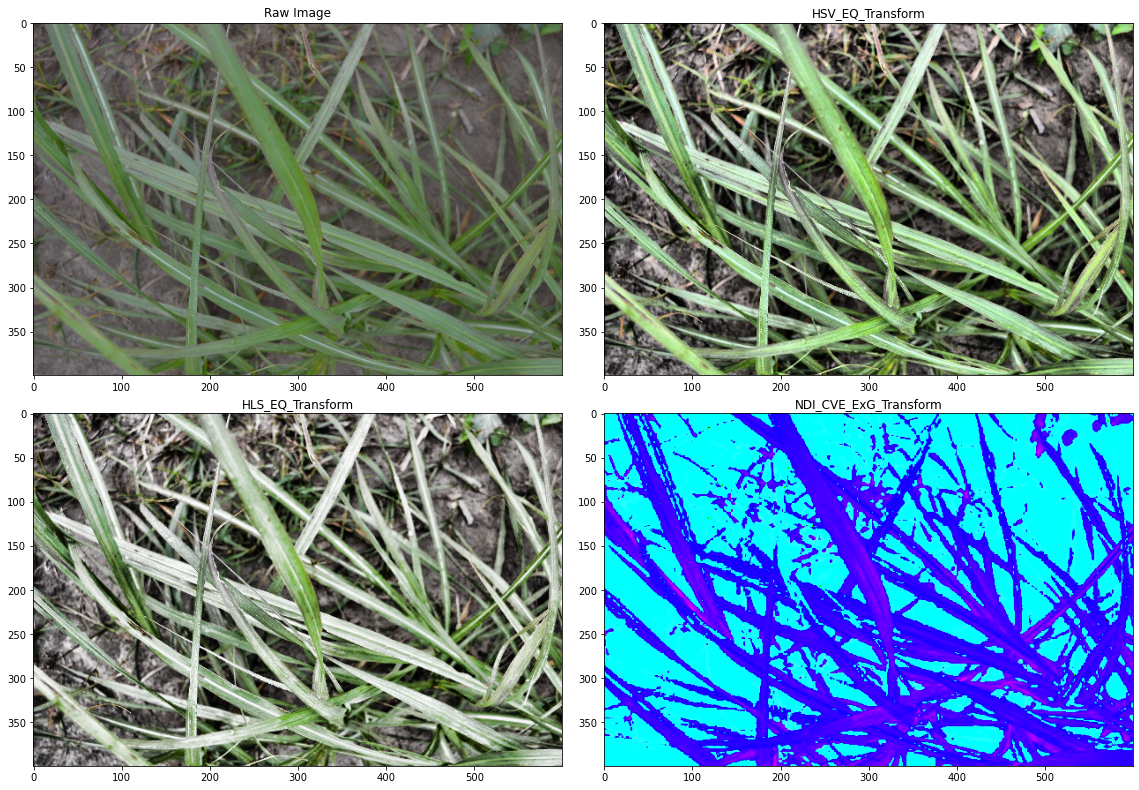

In [86]:
#### Validate Image Color Index Transforms

# Sample a random image
d = random.sample(dataset_dicts, 1)[0]
img = cv2.imread(d["file_name"])
print(d["file_name"])

# Define and apply transforms
tfs = [NoOpTransform(), HSV_EQ_Transform(), HLS_EQ_Transform(), 
       NDI_CIVE_ExG_Transform()]
# not inluding ExG for now bc it's only one channel & requires network structure change

imgs_tf = [tf.apply_image(img)[:, :, ::-1] for tf in tfs]
shapes = [x.shape for x in imgs_tf]

# Plot comparisons
f, axarr = plt.subplots(2,2, figsize=(16,11))
f.tight_layout()
axarr[0,0].imshow(imgs_tf[0])
axarr[0,0].set_title('Raw Image')

axarr[0,1].imshow(imgs_tf[1])
axarr[0,1].set_title('HSV_EQ_Transform')

axarr[1,0].imshow(imgs_tf[2])
axarr[1,0].set_title('HLS_EQ_Transform')

axarr[1,1].imshow(imgs_tf[3])
axarr[1,1].set_title('NDI_CVE_ExG_Transform')

## Build a custom trainer which inherits from default
- Get custom eval metrics while training
- Apply desired augmentations / transformations

In [87]:
def custom_mapper_train(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = []
    # Rotate 90 degrees to landscape if image is in portrait format
    height, width, _ = image.shape
    if height > width:
        transform_list.append(T.RotationTransform)
    transform_list = [T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      NoOpTransform(),
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

def custom_mapper_test(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict) 
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = []
    height, width, _ = image.shape
    if height > width:
        transform_list.append(T.RotationTransform)
    transform_list = [NoOpTransform(),
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

## Define hook for validation loss
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        self._loader = iter(build_detection_train_loader(self.cfg, mapper=custom_mapper_test)) 
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper_train)
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, cfg.DATASETS.TEST[0], mapper=custom_mapper_test)


## Define Training Configs

In [89]:
### TRAINING CONFIG

pretrained_models = ["COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
                     "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
                     "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"]

color_tfs = [NoOpTransform(), HSV_EQ_Transform(), 
             HLS_EQ_Transform(), NDI_CIVE_ExG_Transform()]

m_id = 0
tf_id = 0

# Select base model & initialized weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(pretrained_models[m_id]))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_models[m_id]) 

cfg.DATASETS.TRAIN = ("weeds_train",)
cfg.DATASETS.TEST = ("weeds_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # TODO - tweak
cfg.SOLVER.MAX_ITER = 750   # Adjusted based on validation mAP (500-1500)

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only one class (weed), other class is background

cfg.TEST.EVAL_PERIOD = 100  # every 5 epochs

cfg.OUTPUT_DIR = '/home/mschoder/experiment_outputs/' + \
                 'model_' + str(m_id) + '_' + \
                 'lr_' + str(cfg.SOLVER.BASE_LR) + '_' + \
                 'iters_' + str(cfg.SOLVER.MAX_ITER) + '_' + \
                 'tf_' + str(color_tfs[tf_id]) + '/'


# Set everything up to train, register hooks
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
val_loss = ValidationLoss(cfg)
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)


[11/22 23:03:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


## Train Model

In [91]:
# Look at training curves in tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir output 

In [92]:
# TRAIN
print('Starting training for config: ', cfg.OUTPUT_DIR)
trainer.train()
print('Training succeeded for config: ', cfg.OUTPUT_DIR)

Starting training for config:  /home/mschoder/experiment_outputs/model_0_lr_0.00025_iters_750_tf_NoOpTransform()/
[11/22 23:05:48 d2.engine.train_loop]: Starting training from iteration 0
[11/22 23:07:47 d2.utils.events]:  eta: 0:02:26  iter: 19  total_loss: 1.93  loss_cls: 0.8717  loss_box_reg: 0.5579  loss_rpn_cls: 0.3868  loss_rpn_loc: 0.02787  total_val_loss: 1.93  val_loss_cls: 0.8787  val_loss_box_reg: 0.5506  val_loss_rpn_cls: 0.3819  val_loss_rpn_loc: 0.02937  time: 0.2040  data_time: 0.1678  lr: 4.9953e-06  max_mem: 2958M
[11/22 23:09:38 d2.utils.events]:  eta: 0:02:22  iter: 39  total_loss: 1.699  loss_cls: 0.7302  loss_box_reg: 0.5666  loss_rpn_cls: 0.3775  loss_rpn_loc: 0.02998  total_val_loss: 1.746  val_loss_cls: 0.7391  val_loss_box_reg: 0.5611  val_loss_rpn_cls: 0.3787  val_loss_rpn_loc: 0.02847  time: 0.2501  data_time: 0.0963  lr: 9.9902e-06  max_mem: 2958M
[11/22 23:11:30 d2.utils.events]:  eta: 0:02:25  iter: 59  total_loss: 1.573  loss_cls: 0.5743  loss_box_reg: 0.

FileNotFoundError: [Errno 2] No such file or directory: 'coco_eval/weeds_val_coco_format.json'

Text(0.5, 0, 'Training Iterations')

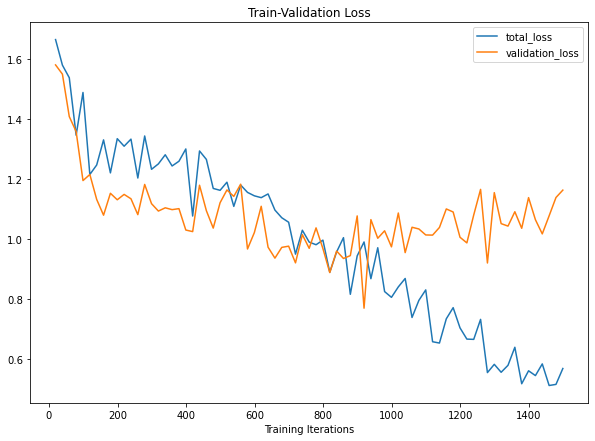

In [78]:
# Plot Train-Validation Loss curve

# experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'
# experiment_folder = '/home/mschoder/sugarcane-weed-classification/models/data/output'
experiment_folder = '/home/mschoder/sugarcane-weed-classification/models/home/mschoder/experiemnt_outputs/model_0_lr_0.00025_iters_1500_tf_NDI_CIVE_ExG_Transform()'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

iters = [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x.keys()]
total_losses = [x['total_loss'] for x in experiment_metrics if 'total_val_loss' in x.keys()]
val_losses = [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x]


plt.figure(figsize=(10,7))
plt.plot(iters, total_losses)
plt.plot(iters, val_losses)
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.title('Train-Validation Loss')
plt.xlabel('Training Iterations')

In [79]:
### Get mAP validation metrics & others
val_loss_metrics = [x for x in experiment_metrics if 'total_val_loss' in x]
# print(len(val_loss_metrics))

bbox_loss_metrics = [x for x in experiment_metrics if 'bbox/AP50' in x]
# print(len(bbox_loss_metrics))

class_acc_metrics = [x for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x]
# print(len(class_acc_metrics))

false_neg_metrics = [x for x in experiment_metrics if 'fast_rcnn/false_negative' in x]
# print(len(false_neg_metrics))


Text(0.5, 0, 'Training Iterations')

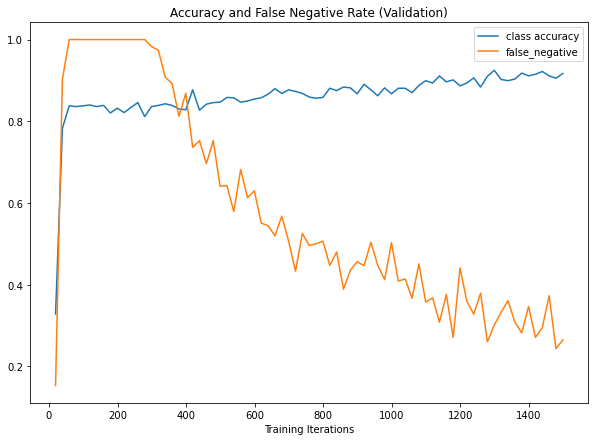

In [80]:
plt.figure(figsize=(10,7))
plt.plot([x['iteration'] for x in class_acc_metrics],
        [x['fast_rcnn/cls_accuracy'] for x in class_acc_metrics])
plt.plot([x['iteration'] for x in false_neg_metrics],
        [x['fast_rcnn/false_negative'] for x in false_neg_metrics])
plt.legend(['class accuracy', 'false_negative'], loc='upper right')
plt.title('Accuracy and False Negative Rate (Validation)')
plt.xlabel('Training Iterations')

Text(0, 0.5, 'Average Precision')

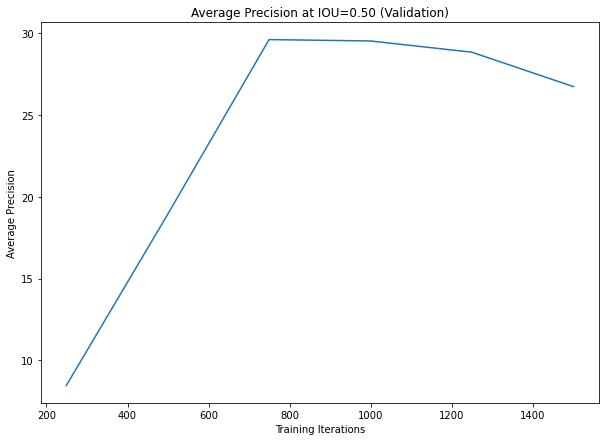

In [81]:
val_ap50 = [x['bbox/AP50'] for x in experiment_metrics if 'bbox/AP50' in x]
val_ap_iters = [x['iteration'] for x in experiment_metrics if 'bbox/AP50' in x]
plt.figure(figsize=(10,7))
plt.plot(val_ap_iters, val_ap50)
plt.title('Average Precision at IOU=0.50 (Validation)')
plt.xlabel('Training Iterations')
plt.ylabel('Average Precision')

## Test Results

In [34]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

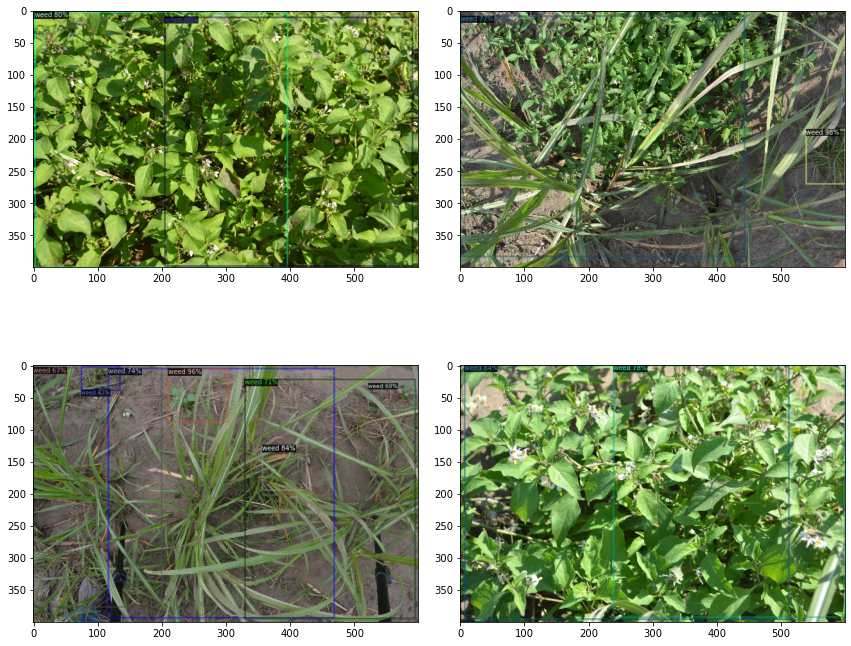

In [35]:
from detectron2.utils.visualizer import ColorMode

fig, axs = plt.subplots(2,2, figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
fig.tight_layout()
axs = axs.ravel()

val_dict = get_weed_dicts(img_dir, file_lists['val'])
for i,d in enumerate(random.sample(val_dict, 4)):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=weeds_metadata, 
                   scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())


In [36]:
outputs

{'instances': Instances(num_instances=2, image_height=400, image_width=600, fields=[pred_boxes: Boxes(tensor([[  6.6239,   0.0000, 512.1963, 395.1682],
         [239.2473,   0.0000, 598.8257, 392.1658]], device='cuda:0')), scores: tensor([0.8411, 0.7769], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}

75
7
75
75


In [59]:
bbox_loss_metrics

[{'bbox/AP': 2.9211955416471964,
  'bbox/AP50': 8.459221266431038,
  'bbox/AP75': 1.4859868208285942,
  'bbox/APl': 5.304919190419157,
  'bbox/APm': 0.236630016467835,
  'bbox/APs': 0.0,
  'iteration': 249},
 {'bbox/AP': 7.376165720893933,
  'bbox/AP50': 18.926606803332273,
  'bbox/AP75': 1.7710713019390742,
  'bbox/APl': 12.974595396428215,
  'bbox/APm': 1.1103545755733213,
  'bbox/APs': 0.0,
  'data_time': 5.258880556000804,
  'eta_seconds': 3204.1126469976007,
  'fast_rcnn/cls_accuracy': 0.8466796875,
  'fast_rcnn/false_negative': 0.6411139821992535,
  'fast_rcnn/fg_cls_accuracy': 0.35888601780074647,
  'iteration': 499,
  'loss_box_reg': 0.7105334997177124,
  'loss_cls': 0.3585888594388962,
  'loss_rpn_cls': 0.074849683791399,
  'loss_rpn_loc': 0.024544065818190575,
  'lr': 0.00012487525,
  'roi_head/num_bg_samples': 104.0,
  'roi_head/num_fg_samples': 24.0,
  'rpn/num_neg_anchors': 241.875,
  'rpn/num_pos_anchors': 14.125,
  'time': 5.508862622999004,
  'total_loss': 1.16262161079

Text(0, 0.5, 'Average Precision')

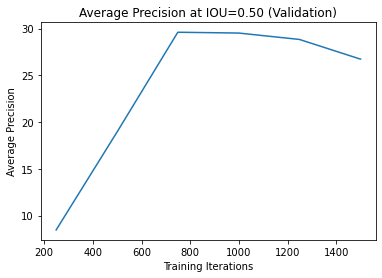

Text(0.5, 0, 'Training Iterations')

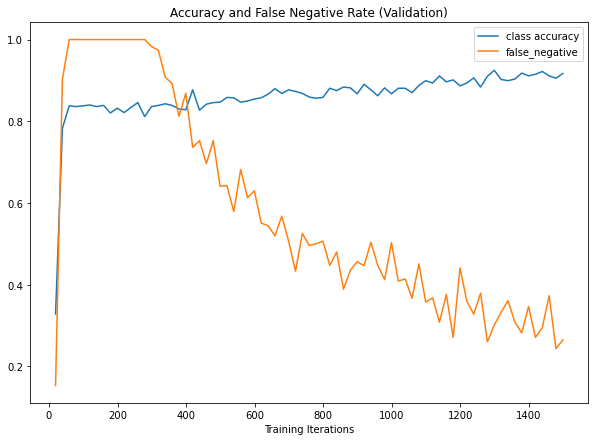